# Stock Time Series Analysis
*Time series analysis of stocks using Pandas and Matplotlib.*

**Attribution Notes**:
* Much of this analysis was inspired by [Cognitir](http://www.cognitir.com/)'s [Introduction to Data Science for Finance](http://www.cognitir.com/courses/data-science) course, which I attended at the Ohio State University in November 2016. I generated this notebook using notes I took during the couse to practice what I learned and add some other functions useful to me. The course provides a much more detailed presentation of the material, and I highly recommend it. I encourage you to [contact them](http://www.cognitir.com/contact) for more information.
* I used [this blog post](https://briandew.wordpress.com/2016/04/09/oil-price-data-with-python/) from Brian Dew as an example for pulling the WTI crude oil price online from [Quandl](https://www.quandl.com/).
* [Chris Albon](http://chrisalbon.com/python/pandas_join_merge_dataframe.html)'s blog is always a great resouce for questions about Pandas. 

In [1]:
%matplotlib inline
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter
import pandas as pd
import pandas_datareader.data as web

### Download Data
Download stock data from Yahoo Finance

In [2]:
# Define Stocks
stocks = ['GE',    # General Electric
          'BRS',   # Bristow
          'ERA',   # ERA Group
          'HELIQ', # CHC
          'BAB'    # Babcock Internaional
         ]

# Define date range
start = datetime.datetime(2016, 1, 1)
end = datetime.datetime.now()

# Read stock data from Yahoo
df = web.DataReader(stocks, 'yahoo', start, end)['Adj Close']
df.tail()

,BAB,BRS,ERA,GE,HELIQ
Date,,,,,
2016-11-18,29.280001,13.85,10.54,30.670000,0.15
2016-11-21,29.309999,14.20,11.12,30.870001,0.15
2016-11-22,29.370001,14.96,11.85,31.180000,0.11
2016-11-23,29.280001,15.40,12.47,31.340000,0.10
2016-11-25,29.250000,15.13,11.34,31.440001,0.11


Download WTI Crude data from Quandl

In [3]:
# Import WTI crude oil price data from Quandl (see https://briandew.wordpress.com/2016/04/09/oil-price-data-with-python/)
url = "https://www.quandl.com/api/v3/datasets/CHRIS/CME_CL1.csv"
wti = pd.read_csv(url, index_col=0, parse_dates=True)
wti = wti.loc[wti.index > start] # select only items in our range
wti = wti[['Last']] # remove all columns except for 'Last'
wti = wti.rename(columns = {'Last':'WTI'}) # rename 'Last' to 'WTI'
wti.head()

,WTI
Date,
2016-11-25,45.96
2016-11-23,47.94
2016-11-22,47.90
2016-11-21,47.48
2016-11-18,45.58


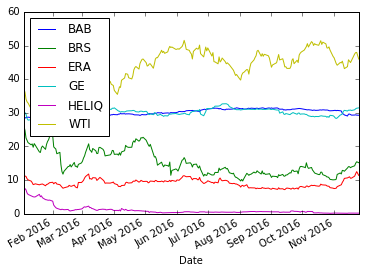

In [4]:
# Merge WTI into stock data
df = df.merge(wti, left_index=True, right_index=True, how='right')
df.head()

# Plot data
df.plot()
plt.show()

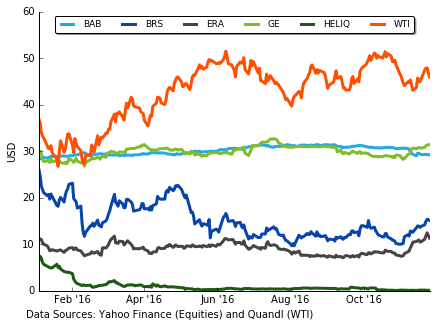

In [5]:
# Produce a more visually appealing plot
colors = ['#25AAE2', '#0745AB', '#454545', '#7FBD2C', '#1F5A13', '#FE5000']
fig = plt.figure(figsize=[7,5])
ax1 = plt.subplot(111)

for i in range(0,len(df.columns)):
    plt.plot(df[[df.columns[i]]], linewidth=3, color=colors[i], label=df.columns[i])
    
ax1.set_ylabel('USD')
ax1.set_xlabel('')
#ax1.set_title('Title', fontsize=18)
ax1.spines["top"].set_visible(False)  
ax1.spines["right"].set_visible(False)  
ax1.get_xaxis().tick_bottom()
ax1.get_yaxis().tick_left()
ax1.tick_params(axis='x', which='major', labelsize=10)
months = MonthLocator(range(1, 13), bymonthday=1, interval=2)
monthsFmt = DateFormatter("%b '%y")
ax1.xaxis.set_major_locator(months)
ax1.xaxis.set_major_formatter(monthsFmt)
fig.text(0.1, 0.05, 'Data Sources: Yahoo Finance (Equities) and Quandl (WTI)')
plt.legend(loc=9, ncol=6, shadow=True, fancybox=True, fontsize=9)
plt.savefig('time-series.png', dpi=1000)

### Resample
See [here for more resampling options](http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases).

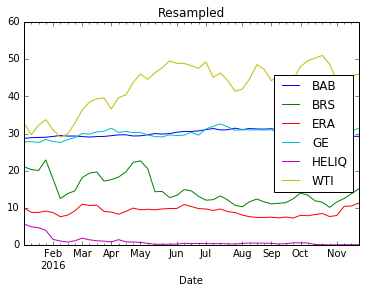

In [6]:
df_resample = df.resample('W').ffill()
df_resample.plot()
plt.title('Resampled')
plt.show()

### Percent Change
See [here for more information](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.pct_change.html) on the Pandas `pct_change` function. 

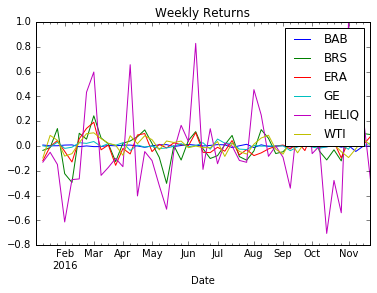

In [7]:
returns = df_resample.pct_change(periods=1)
returns.plot()
plt.title('Weekly Returns')
plt.show()

### Correlations
We can visualize the correlations between the stocks in the selection using the pandas `df.corr()` command and `scatter_matrix` function.

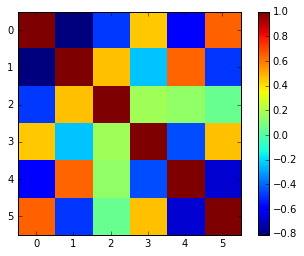

In [8]:
corrs = df.corr()
plt.imshow(corrs, interpolation='nearest')
plt.colorbar()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x115314d30>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1163435c0>]], dtype=object)

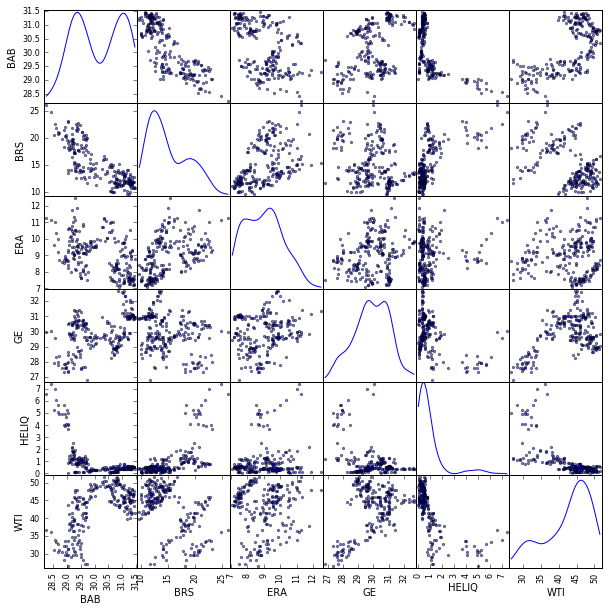

In [9]:
pd.scatter_matrix(df, figsize=(10, 10), diagonal='kde')

### Rolling Average and Bollinger Bands

#### Rolling Average


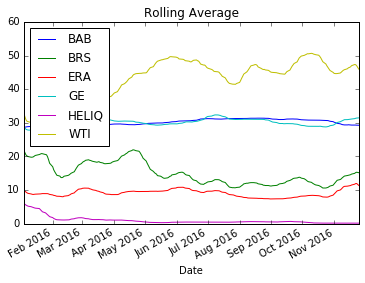

In [10]:
rolling_avg = df.rolling(window=10, min_periods=1).mean()
rolling_avg.plot()
plt.title('Rolling Average')
plt.show()

#### Bollinger Bands
Read more about [Bollinger Bands here](https://en.wikipedia.org/wiki/Bollinger_Bands).

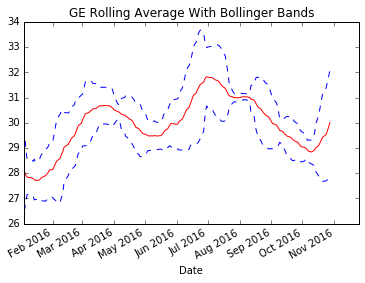

In [11]:
ticker = 'GE'
N = 20 # N and K defined in the equation linked above
K = 2
df = df[[ticker]]
df['rolling_avg'] = df[ticker].rolling(window=N).mean() 
df['boll_upper'] = df['rolling_avg'] + K * df[ticker].rolling(min_periods=N, window=N).std() 
df['boll_lower'] = df['rolling_avg'] - K * df[ticker].rolling(min_periods=N, window=N).std()
df[['boll_lower','boll_upper', 'rolling_avg']].plot(style=['b--', 'b--', 'r'], legend=False)
plt.title(ticker + ' Rolling Average With Bollinger Bands')
plt.show()

See more examples on the [Pandas Computational Tools](http://pandas.pydata.org/pandas-docs/version/0.18.1/computation.html) page.